# Chapter 5: Initial Value Problem

MTH 264 Numerical Methods

Kittapat Ratanaphupha

## Euler method

The fundamental principle of this method is approximating the differential equation as simple as derivative definition. Suppose that there are a first-order differential equation $\dfrac{dy}{dt} = f(y(t),t)$ with the initial value $y(t_0) = y_0$ and ends at $t_1$, this method is recalling a definition of derivative without limit as the same as secant line. The iteration can be written in the form of $y_k = y_{k-1} + \Delta t\; f(y(t), t)$ with $y_0$ as the initial condition of the system.

In [61]:
def euler_method(function, t0, y0, t1, step_size, **kwargs):
    assert step_size > 1e-20, "Step size is too small. It will take the overflow issue."
    assert [type(float(t0)), type(float(t1))] == [float, float], "These variables must be numeric."
    assert t1 > t0, "t1 must be always more than t0."

    y = [y0]
    timeline = [t0]
    t = t0 + step_size
    while t <= t1:
        y_tmp = []
        transformed = function(t, y[-1], **kwargs)
        if type(y0) == list:
            for i in range(len(y0)):
                y_tmp.append(y[-1][i] + step_size * transformed[i])
        else:
            y_tmp = y[-1] + step_size * transformed
        y.append(y_tmp)
        timeline.append(t)
        t += step_size
    return timeline, y

### Recall: matrix calculation from chapter 2
This function is necessary for multiplying a matrix in dynamical systems as we will show below.

In [4]:
def matrix_mul(A, B):
    if type(A[0]) == list:
        len_A0 = len(A[0])
        len_A = len(A)
        assert len(A[0]) == len(B), "Column length of A and row length of B are not equal."
    else:
        len_A0 = len(A)
        len_A = 1
        assert len(A) == len(B), "Column length of A and row length of B are not equal."
    
    x = []

    if type(B[0]) == list: len_B0 = len(B[0])
    else: len_B0 = 1

    for i in range(len_A):
        x_row = []
        for k in range(len_B0):
            summand = 0
            for j in range(len_A0):
                A_mul = A[j] if type(A[0]) != list else A[i][j]
                B_mul = B[j] if type(B[0]) != list else B[j][k]
                summand += A_mul * B_mul
            x_row.append(summand)
        x.append(x_row if type(B[0]) == list else x_row[0])
    return x if (type(x[0]) == list) or (len(x) > 1) else x[0]

### Dynamical systems: simple harmonic oscillators

In generally, as linear assumptions of elastic force, the simple harmonic oscillator can be written as,
$$\frac{d^2x}{dt^2}+\omega^2 x = 0,$$
as the case of normal SHO w/o external forces.

For numerical methods, we can solve it by using linear systems relation. Assigning $x$ and $v$ as variable in row matrix, the system can be formed like this,
$$\mathbf{Ay} = \begin{pmatrix} \dfrac{dx}{dt} \\ \dfrac{dv}{dt} \end{pmatrix} = \begin{pmatrix} 0 & 1 \\ -\omega^2 & 0 \end{pmatrix}\begin{pmatrix} x \\ v \end{pmatrix}.$$

When we can write dynamical system equation like this, the implementation could not be difficult than the first sight. We can iterate the function as the Euler's method has defined before,
$$\mathbf{y}_k = \mathbf{y}_{k-1} + \Delta t \cdot \mathbf{Ay}_{k-1}.$$

In [8]:
def simple_harmonic(t, y, omega = 4):
    shm_matrix = [[0,1],[-omega**2, 0]]
    return matrix_mul(shm_matrix, y)

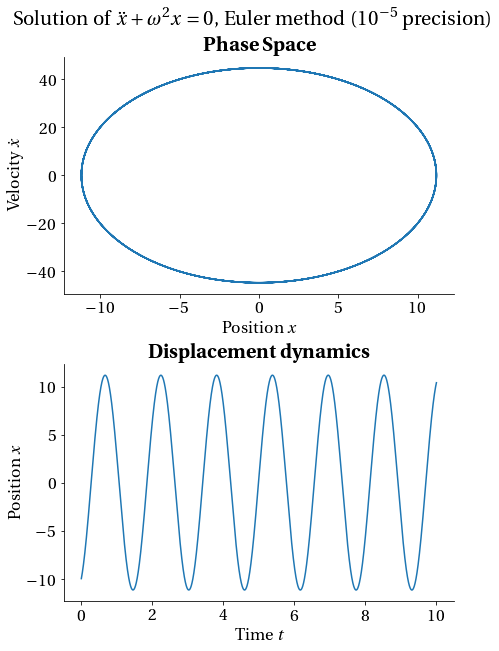

In [174]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('text', usetex=True)
matplotlib.rc('font', size=18)
matplotlib.rc('legend', fontsize=18)
matplotlib.rc('text.latex', preamble=r'\usepackage{fourier}')
plt.rcParams["font.family"] = "serif"

t, y = euler_method(simple_harmonic, 0, [-10, 20], 10, 1e-5)
x = []
v = []
for i in y:
    x.append(i[0])
    v.append(i[1])

fig, (ax1, ax2) = plt.subplots(figsize=(7,10), nrows = 2)
plt.subplots_adjust(hspace = 0.3)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax1.plot(x,v)
ax1.set_xlabel(r"Position $x$")
ax1.set_ylabel(r"Velocity $\dot x$")
ax1.set_title(r"\textbf{Phase Space}")

ax2.plot(t,x)
ax2.set_xlabel(r"Time $t$")
ax2.set_ylabel(r"Position $x$")
ax2.set_title(r"\textbf{Displacement dynamics}")

fig.suptitle(r"Solution of ${\ddot x} + \omega^2 x = 0$, Euler method ($10^{-5}$ precision)", y = 0.95)
plt.show()

### Precision checking
This function is for testing a precision and error convergence in each method, so we solve the differential equation below,
$$\frac{dy}{dt} = t^2+2t+5.$$

In [102]:
def parabola(t, y, a = 0.1, b = 2, c = 5):
    return a * t ** 2 + b * t + c

def solution_parabola(t0, y0, t1, a = 0.1, b = 2, c = 5):
    return a * (t1 ** 3 - t0 ** 3) / 3 + b * (t1 ** 2 - t0 ** 2) / 2 + c * (t1 - t0) + y0

### Source of error in Euler method
The error from the mentioned method can emerge from 2 possibilities: truncation and round-off.

1. Truncation error: this error comes from the neglected terms of smooth functions. We can write $f(t + h)$ in Taylor expansion for smooth function as:
$$ y(t + h) = y(t) + h\dfrac{dy}{dt}(t) + \dfrac{h^2}{2}\dfrac{d^2y}{dt^2}(t) + o(h^3). $$

1.1. The local truncation error will equal to $ \dfrac{h^2}{2}\dfrac{d^2y}{dt^2}(t) + o(h^3)$. If we ignore a higher order terms of remainder in Taylor expansion, using mean value theorem instead, the local truncation error will be lastly $\dfrac{h^2}{2}\dfrac{d^2y}{dt^2}(c)$ as $c \in [t, t+h]$.

1.2. The global truncation error: if we consider that the function we interested is Lipschitz continuous, the error will be aggregated as $|e_{i+1}| \leq |e_i| + h|f(x_i,y(x_i))-f(x_i,y_i)| + \dfrac{Mh^2}{2} \leq C|e_i| + \dfrac{Mh^2}{2} $ that $|e_0| = 0$. We can rearrange it into the geometric series as $|e_n| \leq \sum_{i=0}^{n-1} C^i \dfrac{Mh^2}{2}$ that gives the final result as $K = M\dfrac{\exp(R(b-x_0))-1}{2R}$ that $|y(b)-y_n| \leq Kh$, based on Lipschitz condition, where $R$ is Lipschitz constant from the term $|f(x_i,y(x_i))-f(x_i,y_i)|$, $x_0$ is initial point, and $b$ is final point of iteration.

2. Round-off error: the error comes from machine epsilon that have limited capacity to calculate high precision floating points.

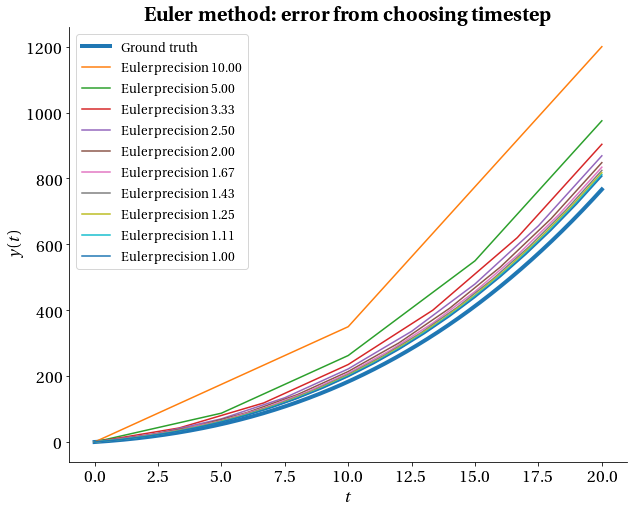

In [113]:
import numpy as np

X = np.arange(0, 20, 1e-5)
fig, ax = plt.subplots(figsize = (10,8))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.plot(X, solution_parabola(0, 0, X), label = "Ground truth", linewidth = 4)
for i in range(1,11):
    plt.plot(*euler_method(parabola, 0, 0, 20, 10 / i), label = r"Euler precision %.2f" % (10 / i))
plt.legend(fontsize = 14)
plt.title(r"\textbf{Euler method: error from choosing timestep}")
plt.xlabel("$t$")
plt.ylabel("$y(t)$")
plt.show()

## Runge-Kutta method: Fourth-order
The Runge-Kutta Method is an algorithm which solves an initial value problem in higher order than Euler method. What the method do is estimating higher order derivative in the sense of function composition. When we know $f(y(t), t)$ that means the first derivative has known and usable for IVP. For this file, RK4 is the example for solving IVP in RK family.

In RK4, the equation can be expressed as,
$$y_{n+1} = y_{n} + \dfrac{k_1 + 2k_2 + 2k_3 + k_4}{6}h$$
where $h$ is step size, and $k_i$ have relations in the manner of the following,
$$k_1 = hf(y(t),t)$$
$$k_2 = hf(y+k_1/2, t+h/2)$$
$$k_3 = hf(yk_2/2, t+h/2)$$
$$k_4 = hf(yk_3, t+h)$$

In [157]:
def RK4(function, t0, y0, t1, step_size, **kwargs):
    assert step_size > 1e-20, "Step size is too small. It will take the overflow issue."
    assert [type(float(t0)), type(float(t1))] == [float, float], "These variables must be numeric."
    assert t1 > t0, "t1 must be always more than t0."

    y = [y0]
    timeline = [t0]
    t = t0
    while t + step_size <= t1:
        y_tmp = []
        k1 = function(t, y[-1], **kwargs)
        k = [k1]
        if type(y0) == list:
            for i in range(2, 5):
                yk = []
                for j in range(len(y0)):
                    yk.append(y[-1][j] + k[-1][j] * step_size * (1 if i == 4 else 1/2))
                if i == 4: k.append(function(t + step_size, yk))
                else: k.append(function(t + step_size / 2, yk))
            for n in range(len(y0)):
                y_tmp.append(y[-1][n] + step_size * (k[0][n] + 2 * (k[1][n] + k[2][n]) + k[3][n])/6)
        else:
            for i in range(2, 5):
                if i == 4: k.append(function(t + step_size, y[-1] + k[-1] * step_size))
                else: k.append(function(t + step_size / 2, y[-1] + k[-1] * step_size / 2))
            y_tmp = y[-1] + step_size * (k[0] + 2 * (k[1] + k[2]) + k[3])/6
        
        y.append(y_tmp)
        t += step_size
        timeline.append(t)
    return timeline, y

### Error analysis
In this method, we know that the truncation error is approximately $O(h^5)$ according to Taylor series approximation in residual terms, but there is no exact factor to analyze that has already verified by proof.

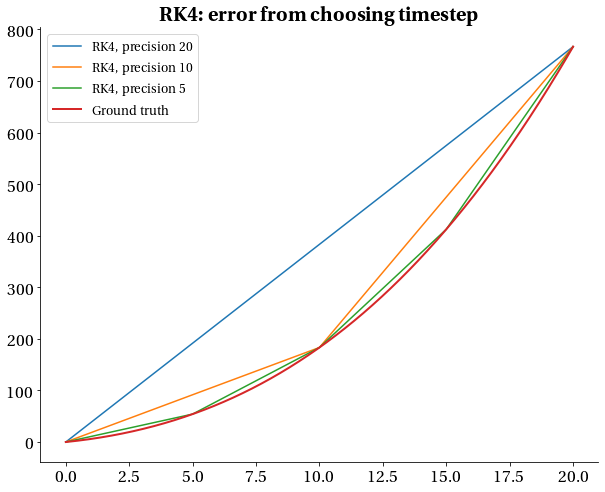

In [184]:
fig, ax = plt.subplots(figsize = (10,8))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.plot(*RK4(parabola, 0, 0, 20, 20), label = "RK4, precision 20")
plt.plot(*RK4(parabola, 0, 0, 20, 10), label = "RK4, precision 10")
plt.plot(*RK4(parabola, 0, 0, 20, 5), label = "RK4, precision 5")
plt.plot(X, solution_parabola(0, 0, X), label = "Ground truth", linewidth = 2)
plt.legend(fontsize = 14)
plt.title(r"\textbf{RK4: error from choosing timestep}")
plt.show()

### RK4 in dynamical systems
The same problem that is solved by Euler method is recalled for checking abilities to solve IVP in dynamical systems.

In [176]:
t, y = RK4(simple_harmonic, 0, [-10, 20], 10, 0.1)

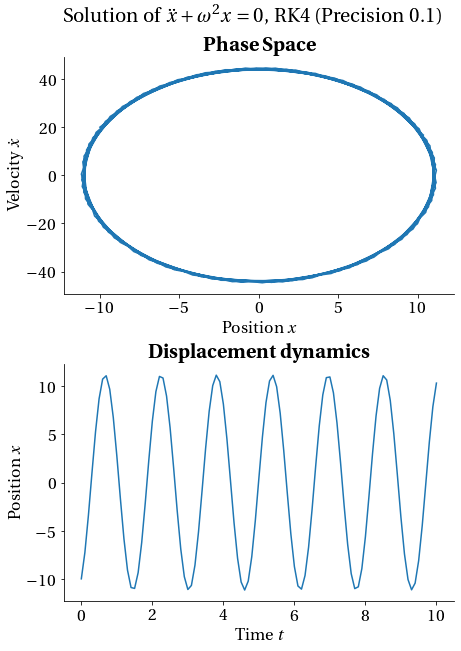

In [180]:
x = []
v = []
for i in y:
    x.append(i[0])
    v.append(i[1])

fig, (ax1, ax2) = plt.subplots(figsize=(7,10), nrows = 2)
plt.subplots_adjust(hspace = 0.3)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax1.plot(x,v)
ax1.set_xlabel(r"Position $x$")
ax1.set_ylabel(r"Velocity $\dot x$")
ax1.set_title(r"\textbf{Phase Space}")

ax2.plot(t,x)
ax2.set_xlabel(r"Time $t$")
ax2.set_ylabel(r"Position $x$")
ax2.set_title(r"\textbf{Displacement dynamics}")

fig.suptitle(r"Solution of ${\ddot x} + \omega^2 x = 0$, RK4 (Precision 0.1)", y = 0.95)
plt.show()

## Summary
| Algorithm | Inspired from | Truncation error | Overall runtime |
|---|---|---|---|
| Euler Method | Definition of derivative without limit, personal determined $\epsilon$ | $O(h^2)$ | Slow for getting high precision |
| RK4 | Taylor expansions to the fourth-order term | $O(h^5)$ | Faster compared with Euler method in the same precision |